<h1>DSCI-552 Homework 4</h1>
<br>
<font size="4">Morgan Gautho | GitHub: morgangauth | 3944-8632-72</font>
    

In [53]:
import pandas as pd
import numpy as np
import glob
import os
from scipy.stats import bootstrap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.feature_selection import RFECV 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.naive_bayes import MultinomialNB,GaussianNB

from sklearn import svm, datasets
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
!pip install imbalanced-learn
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

import warnings
warnings.filterwarnings('ignore')

## 1. Time Series Classification Part 1: Feature Creation/Extraction



### 1. (a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29 .

In [54]:
folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
colNames = ['# Columns: time','avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
parentFolder = "../data/AReM/"

data = pd.DataFrame()
instanceIdx = 0;
for f in folders:
    # open folder, 
    folderFiles = os.listdir(parentFolder + f)
    idx = 1;
    for c in folderFiles:
        filePath = parentFolder + f + "/" + c
        if((f == folders[1]) & (c == 'dataset4.csv')):
            df = pd.read_csv(filePath, skiprows = 5, sep = ' ', names = colNames, usecols = range(7))
        else:
            df = pd.read_csv(filePath, header = 4, usecols = colNames)
        df['instance'] = instanceIdx
        df['folder'] = f
        df['dataset'] = idx
        if 'bending' in f:
            df['isBending'] = 1
        else:
            df['isBending'] = 0
        idx += 1
        instanceIdx += 1
        data = pd.concat([data, df], ignore_index=True, axis=0)
    
print(data.head())
            
        



   # Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                0      39.25       0.43      22.75       0.43      33.75   
1              250      39.25       0.43      23.00       0.00      33.00   
2              500      39.25       0.43      23.25       0.43      33.00   
3              750      39.50       0.50      23.00       0.71      33.00   
4             1000      39.50       0.50      24.00       0.00      33.00   

   var_rss23  instance    folder  dataset  isBending  
0        1.3         0  bending1        1          1  
1        0.0         0  bending1        1          1  
2        0.0         0  bending1        1          1  
3        0.0         0  bending1        1          1  
4        0.0         0  bending1        1          1  


### 1. (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [55]:
test_data = data[((data['isBending'] == 1) & (data['dataset'] < 3)) | ((data['isBending'] == 0) & (data['dataset'] < 4))]

train_data = data[((data['isBending'] == 1) & (data['dataset'] > 2)) | ((data['isBending'] == 0) & (data['dataset'] > 3))]

### 1. (c) Feature Extraction: Classification of time series usually needs extracting features from them. In thisproblem, we focus on time-domain features.
#### i.  Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).


Time-domain features usually used in time series classification are: 
mean, standard deviation, maximum/minimum values, median, skewness, kurtosis

### 1. (c) ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [56]:
timeFeatures = pd.DataFrame()
idx = 0;
for f in folders:
    # open folder, 
    folderFiles = os.listdir(parentFolder + f)
    datasetIdx = 1
    for c in folderFiles:
        filePath = parentFolder + f + "/" + c
        if((f == folders[1]) & (c == 'dataset4.csv')):
            df = pd.read_csv(filePath, skiprows = 5, sep = ' ', names = colNames, usecols = range(7))
        else:
            df = pd.read_csv(filePath, header = 4, usecols = colNames)
        dataDictionary = {}
        dataDictionary['instance'] = idx
        dataDictionary['folderFile'] = f+"/"+c
        if 'bending' in f:
            dataDictionary['isBending'] = 1
        else:
            dataDictionary['isBending'] = 0
        dataDictionary['isTrain'] = (((f==folders[1]) | (f == folders[2])) & (datasetIdx > 2)) | (((f!=folders[1]) & (f != folders[2])) & (datasetIdx > 3))
        for i in range(1, np.size(colNames)):
            col = df.iloc[:,i]
            colDetails = pd.DataFrame(col.describe()).transpose()
            dataDictionary['min'+ str(i)] = colDetails['min'][0]
            dataDictionary['max'+ str(i)] = colDetails["max"][0]
            dataDictionary['mean'+ str(i)] = colDetails["mean"][0]
            dataDictionary['median'+ str(i)] = colDetails["50%"][0]
            dataDictionary['std'+ str(i)] = colDetails["std"][0]
            dataDictionary['1stQ'+ str(i)] = colDetails["25%"][0]
            dataDictionary['3rdQ'+ str(i)] = colDetails["75%"][0]
        timeFeatures = timeFeatures.append(dataDictionary, ignore_index=True)
        idx += 1
        datasetIdx += 1
        
timeFeatures = timeFeatures.set_index('instance')
display(timeFeatures)




folderFile  isBending  isTrain   min1   max1      mean1  \
instance                                                                       
0         bending1/dataset1.csv          1    False  37.25  45.00  40.624792   
1         bending1/dataset2.csv          1    False  38.00  45.67  42.812812   
2         bending1/dataset3.csv          1    False  35.00  47.40  43.954500   
3         bending1/dataset4.csv          1     True  33.00  47.75  42.179813   
4         bending1/dataset5.csv          1     True  33.00  45.75  41.678063   
...                         ...        ...      ...    ...    ...        ...   
83         walking/dataset5.csv          0     True  20.75  46.25  34.763333   
84         walking/dataset6.csv          0     True  21.50  51.00  34.935813   
85         walking/dataset7.csv          0     True  18.33  47.67  34.333042   
86         walking/dataset8.csv          0     True  18.33  45.75  34.599875   
87         walking/dataset9.csv          0     True  15.50  43.67  34.225875   

          median1      std1  1stQ1    3rdQ1  ...      std5    1stQ5  3rdQ5  \
instance                                     ...                             
0          40.500  1.476967  39.25  42.0000  ...  2.188449  33.0000  36.00   
1          42.500  1.435550  42.00  43.6700  ...  1.995255  32.0000  34.50   
2          44.330  1.558835  43.00  45.0000  ...  1.999604  35.3625  36.50   
3          43.500  3.670666  39.15  45.0000  ...  3.849448  30.4575  36.33   
4          41.750  2.243490  41.33  42.7500  ...  2.411026  28.4575  31.25   
...           ...       ...    ...      ...  ...       ...      ...    ...   
83         35.290  4.742208  31.67  38.2500  ...  3.174681  14.2500  18.33   
84         35.500  4.645944  32.00  38.0625  ...  3.192058  14.2375  18.25   
85         34.750  4.948770  31.25  38.0000  ...  3.000493  13.7500  18.00   
86         35.125  4.731790  31.50  38.0000  ...  2.905688  14.0000  18.25   
87         34.750  4.441798  31.25  37.2500  ...  2.992920  14.3300  18.25   

          min6   max6     mean6  median6      std6  1stQ6   3rdQ6  
instance                                                           
0          0.0   1.92  0.570583    0.430  0.582915   0.00  1.3000  
1          0.0   3.11  0.571083    0.430  0.601010   0.00  1.3000  
2          0.0   1.79  0.493292    0.430  0.513506   0.00  0.9400  
3          0.0   2.18  0.613521    0.500  0.524317   0.00  1.0000  
4          0.0   1.79  0.383292    0.430  0.389164   0.00  0.5000  
...        ...    ...       ...      ...       ...    ...     ...  
83         0.0   9.39  3.288271    3.270  1.647528   2.05  4.3050  
84         0.0  10.21  3.280021    3.015  1.700918   2.12  4.5000  
85         0.0   8.01  3.261583    2.980  1.617290   2.05  4.3200  
86         0.0   8.86  3.289542    3.015  1.680170   2.12  4.2600  
87         0.0   9.42  3.479542    3.270  1.761146   2.24  4.5375  

[88 rows x 45 columns]

### 1. (c) iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootstrap confidence interval for the standard deviation of each feature.


In [57]:
featuresStd = pd.DataFrame({"std":timeFeatures.std()})
featuresStd = featuresStd.iloc[2:]
intervals = []
for i in range(3, np.shape(timeFeatures)[1]):
    col = timeFeatures.iloc[:,i]
    col = (col,)
    bootstrap_ci = bootstrap(col, np.std, confidence_level= 0.9, method='basic')
    intervals.append(bootstrap_ci.confidence_interval)
featuresStd["confidence_interval"] = intervals

display(featuresStd)


std                          confidence_interval
min1     9.569975      (8.325249836895729, 10.800168996667233)
max1     4.394362       (3.476499368794605, 5.412085180546625)
mean1    5.335718      (4.758712299948127, 5.9283166666957685)
median1  5.440054       (4.853195489531584, 6.042099942836743)
std1     1.772153      (1.584261810285582, 1.9639830722998834)
1stQ1    6.153590       (5.617474299738366, 6.690699086395445)
3rdQ1    5.138925      (4.4168281465408885, 5.918003858324854)
min2     0.000000                                   (0.0, 0.0)
max2     5.062729       (4.689435139067283, 5.469422064857092)
mean2    1.574164      (1.4334490349575162, 1.742703519417114)
median2  1.412244      (1.2733409512898406, 1.573552493664352)
std2     0.884105     (0.8202567743982958, 0.9601023986350624)
1stQ2    0.946386      (0.8542824290254107, 1.058811180740358)
3rdQ2    2.125266     (1.9472304692434843, 2.3375719695111554)
min3     2.956462     (2.7850652785676986, 3.1343489978901657)
max3     4.875137       (4.257001457030579, 5.543549871211235)
mean3    4.008380       (3.501513066550281, 4.560858699328196)
median3  4.036396      (3.5109319425976713, 4.615524633642741)
std3     0.946710     (0.7658403429589355, 1.1267171180712376)
1stQ3    4.220658       (3.713569025481866, 4.786479278797137)
3rdQ3    4.171628      (3.6381521093724754, 4.764527818901222)
min4     0.000000                                   (0.0, 0.0)
max4     2.183625     (1.9942721366781941, 2.3768986876975253)
mean4    1.166114     (1.1030316830944134, 1.2508072564739603)
median4  1.145586     (1.0836832844314819, 1.2297988367343837)
std4     0.458242     (0.4277692388932674, 0.4914718395405811)
1stQ4    0.843620     (0.7919990377717241, 0.9077194827968769)
3rdQ4    1.552504      (1.470808966828138, 1.6612716401579553)
min5     6.124001       (4.678646596313692, 7.759512558175402)
max5     5.741238       (4.903424461721099, 6.673334131479421)
mean5    5.675593       (4.587894088860632, 6.879629862757641)
median5  5.813782       (4.700563653338164, 7.066060479973328)
std5     1.024898     (0.8267389035580792, 1.2312261940367213)
1stQ5    6.096465       (4.971391444685758, 7.354906106218422)
3rdQ5    5.531720       (4.504320163877261, 6.652220609534687)
min6     0.045838  (0.013124961748951336, 0.09115393165518615)
max6     2.518921      (2.2691130719709998, 2.781215610972198)
mean6    1.154812      (1.0891307173315314, 1.242869837573214)
median6  1.086474     (1.0191091234369876, 1.1689506065720603)
std6     0.517617     (0.4871848562346198, 0.5534350302729092)
1stQ6    0.758584     (0.7045600282910294, 0.8235063057224531)
3rdQ6    1.523599     (1.4383640018489283, 1.6325770039640457)

### 1. (c) iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).


I believe mean, standard deviation and median are the three most important time-domain features. 

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression3
#### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).4

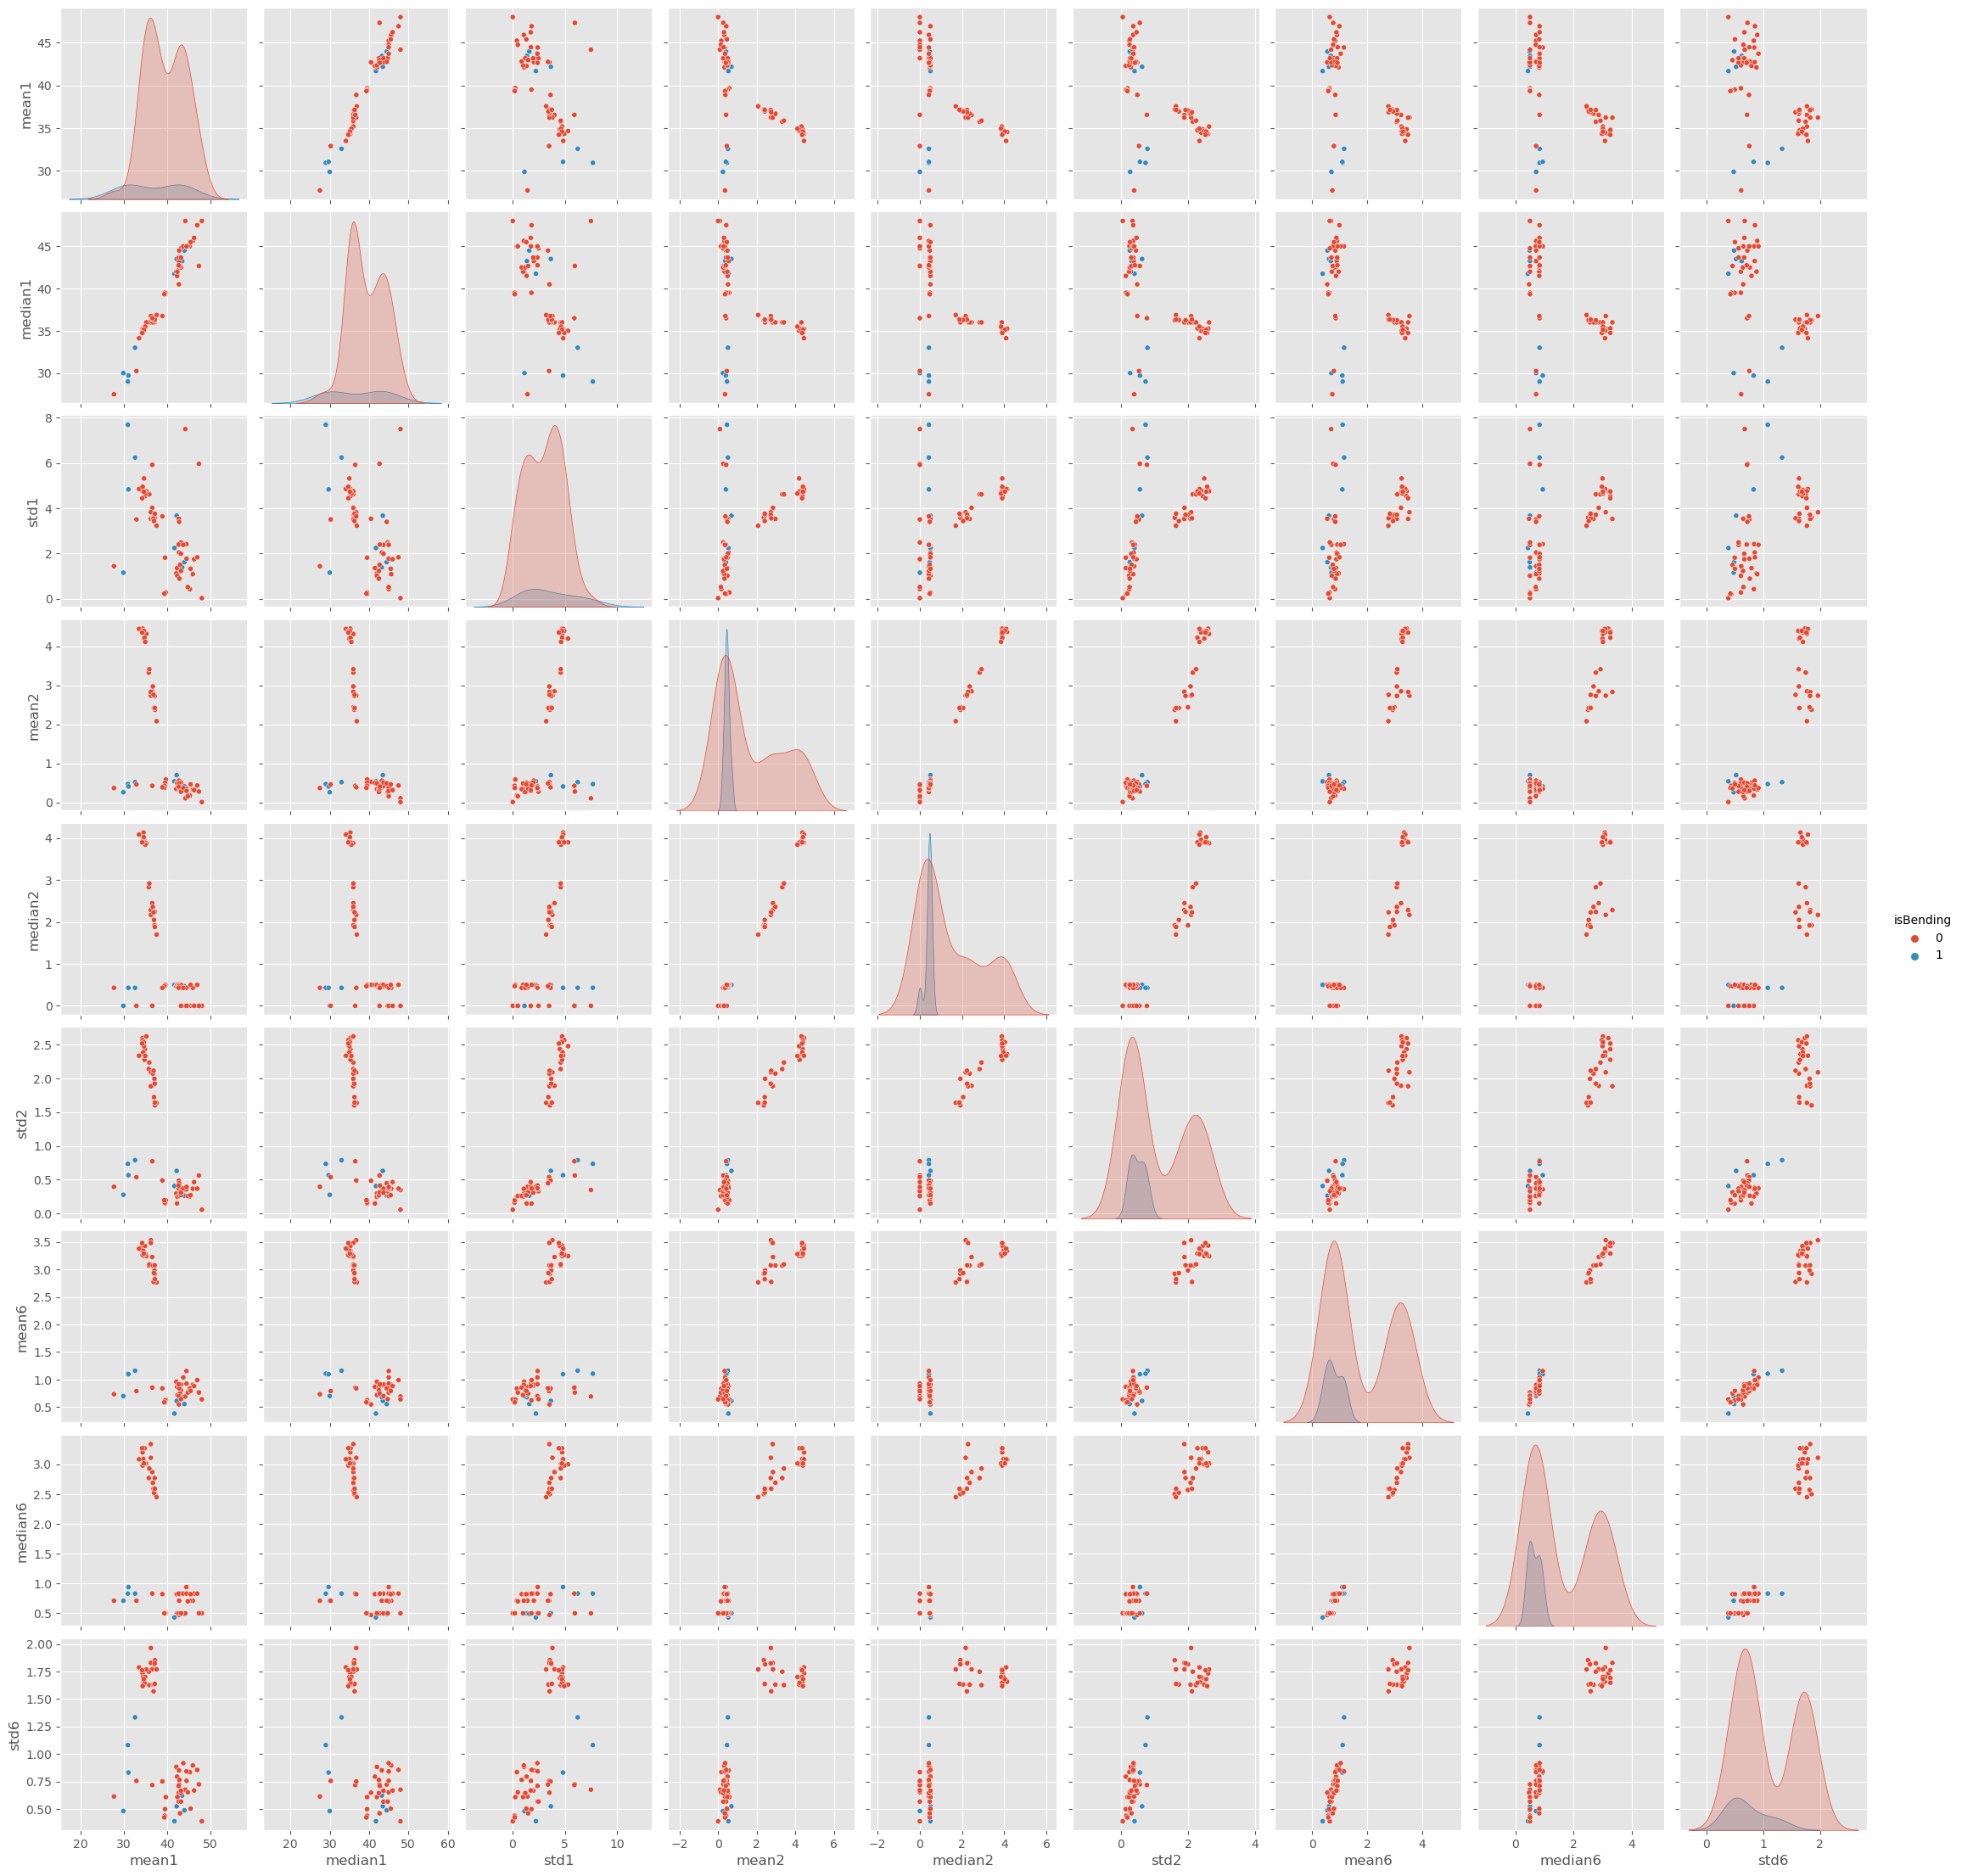

In [58]:
trainFeatures = timeFeatures[timeFeatures["isTrain"]==True]
trainFeatures = trainFeatures[['isBending','mean1', 'median1', 'std1', 'mean2', 'median2', 'std2','mean6', 'median6', 'std6']]
sns.pairplot(trainFeatures, hue = "isBending", plot_kws=dict(s=20))
plt.show()

### 2. (a) ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

folderFile  isBending  isTrain   min1   max1      mean1  \
instance                                                                       
0         bending1/dataset1.csv          1    False  38.00  42.33  40.946958   
1         bending1/dataset2.csv          1    False  41.75  44.25  42.643292   
2         bending1/dataset3.csv          1    False  36.50  46.50  44.057167   
3         bending1/dataset4.csv          1     True  33.75  47.75  43.278875   
4         bending1/dataset5.csv          1     True  33.00  45.75  41.621208   
...                         ...        ...      ...    ...    ...        ...   
83         walking/dataset5.csv          0     True  22.33  46.00  34.966250   
84         walking/dataset6.csv          0     True  21.50  45.67  34.737042   
85         walking/dataset7.csv          0     True  18.33  45.00  33.886458   
86         walking/dataset8.csv          0     True  18.33  44.00  34.836458   
87         walking/dataset9.csv          0     True  23.00  42.75  34.329333   

          median1      std1    1stQ1    3rdQ1  ...      std6   1stQ6   3rdQ6  \
instance                                       ...                             
0          41.250  1.102963  40.3100  42.0000  ...  0.647856  0.0000  1.3000   
1          42.500  0.641849  42.0000  43.3300  ...  0.624834  0.0000  1.3000   
2          44.500  1.556971  43.2500  45.0000  ...  0.526656  0.0000  1.0000   
3          45.000  3.473355  42.0000  45.2500  ...  0.554542  0.0000  1.2200   
4          42.330  3.118644  39.6525  44.2500  ...  0.411200  0.0000  0.7100   
...           ...       ...      ...      ...  ...       ...     ...     ...   
83         35.500  4.733014  32.0000  38.7500  ...  1.638218  1.7975  4.2175   
84         35.500  4.276717  32.0000  37.7500  ...  1.737573  2.1800  4.5125   
85         34.375  5.143776  30.4575  37.5000  ...  1.565557  2.0500  4.2250   
86         35.750  4.869092  32.0000  38.6900  ...  1.647640  2.0600  4.1200   
87         34.710  4.549837  31.3100  37.5425  ...  1.725690  2.1200  4.2450   

          min12  max12    mean12  median12     std12  1stQ12  3rdQ12  
instance                                                              
0          0.00   1.92  0.550544      0.43  0.510945    0.00   0.940  
1          0.00   3.11  0.535816      0.43  0.575225    0.00   0.870  
2          0.00   1.50  0.387992      0.00  0.479503    0.00   0.710  
3          0.00   2.18  0.583431      0.47  0.491182    0.00   0.870  
4          0.00   1.50  0.346987      0.43  0.363819    0.00   0.500  
...         ...    ...       ...       ...       ...     ...     ...  
83         0.00   9.39  3.420628      3.35  1.644726    2.17   4.415  
84         0.00  10.21  3.221799      3.08  1.667596    2.05   4.380  
85         0.00   8.01  3.279414      2.96  1.672532    2.05   4.455  
86         0.47   8.84  3.416192      3.11  1.707474    2.17   4.370  
87         0.43   9.12  3.582971      3.30  1.796108    2.29   4.730  

[88 rows x 87 columns]

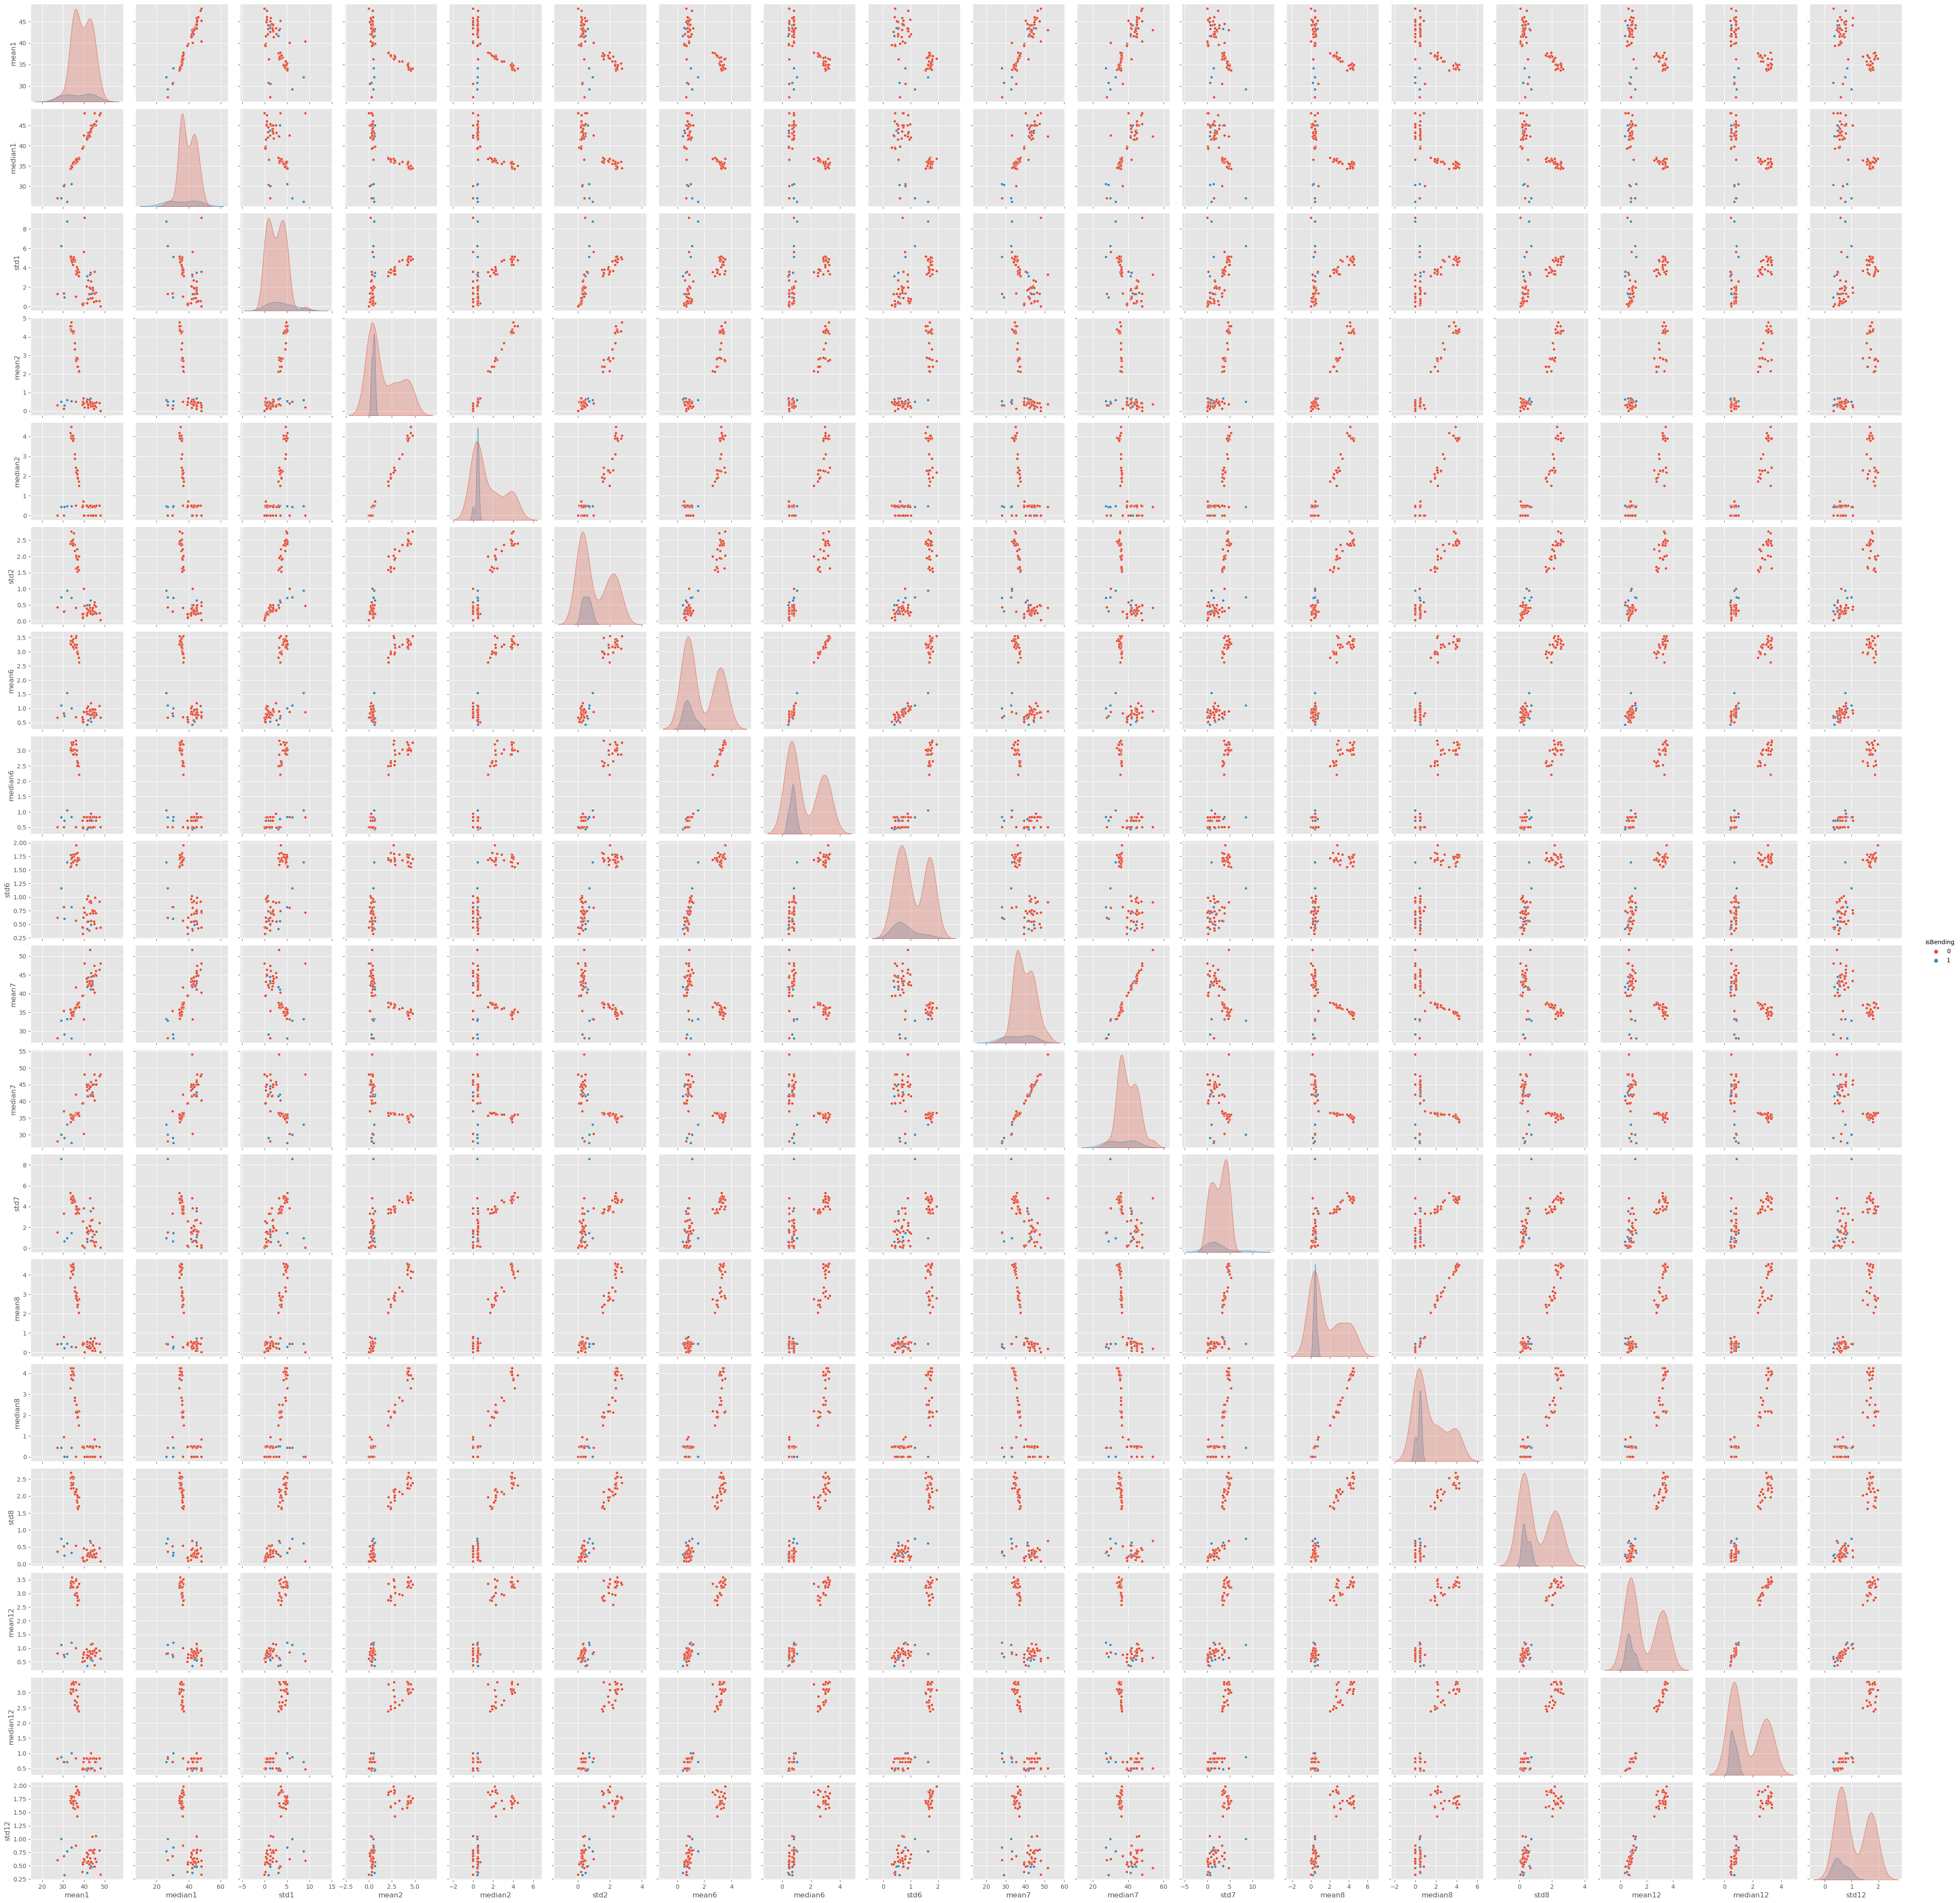

In [59]:
# repeat extraction
twoTimeFeatures = pd.DataFrame()
idx = 0;
for f in folders:
    # open folder, 
    folderFiles = os.listdir(parentFolder + f)
    datasetIdx = 1
    for c in folderFiles:
        filePath = parentFolder + f + "/" + c
        if((f == folders[1]) & (c == 'dataset4.csv')):
            df = pd.read_csv(filePath, skiprows = 5, sep = ' ', names = colNames, usecols = range(7))
        else:
            df = pd.read_csv(filePath, header = 4, usecols = colNames)
        dataDictionary = {}
        dataDictionary['instance'] = idx
        dataDictionary['folderFile'] = f+"/"+c
        if 'bending' in f:
            dataDictionary['isBending'] = 1
        else:
            dataDictionary['isBending'] = 0
        dataDictionary['isTrain'] = (((f==folders[1]) | (f == folders[2])) & (datasetIdx > 2)) | (((f!=folders[1]) & (f != folders[2])) & (datasetIdx > 3))
        for i in range(1, np.size(colNames)):
            halfPoint = int(df.shape[0]/2)
            col1 = df.iloc[:halfPoint,i]
            col2 = df.iloc[halfPoint+1:,i]
            colDetails = pd.DataFrame(col1.describe()).transpose()
            dataDictionary['min'+ str(i)] = colDetails['min'][0]
            dataDictionary['max'+ str(i)] = colDetails["max"][0]
            dataDictionary['mean'+ str(i)] = colDetails["mean"][0]
            dataDictionary['median'+ str(i)] = colDetails["50%"][0]
            dataDictionary['std'+ str(i)] = colDetails["std"][0]
            dataDictionary['1stQ'+ str(i)] = colDetails["25%"][0]
            dataDictionary['3rdQ'+ str(i)] = colDetails["75%"][0]
            colDetails = pd.DataFrame(col2.describe()).transpose()
            dataDictionary['min'+ str(i+6)] = colDetails['min'][0]
            dataDictionary['max'+ str(i+6)] = colDetails["max"][0]
            dataDictionary['mean'+ str(i+6)] = colDetails["mean"][0]
            dataDictionary['median'+ str(i+6)] = colDetails["50%"][0]
            dataDictionary['std'+ str(i+6)] = colDetails["std"][0]
            dataDictionary['1stQ'+ str(i+6)] = colDetails["25%"][0]
            dataDictionary['3rdQ'+ str(i+6)] = colDetails["75%"][0]
        twoTimeFeatures = twoTimeFeatures.append(dataDictionary, ignore_index=True)
        idx += 1
        datasetIdx += 1
        
twoTimeFeatures = twoTimeFeatures.set_index('instance')
display(twoTimeFeatures)

twoTrainFeatures = twoTimeFeatures[twoTimeFeatures["isTrain"]==True]

twoTrainFeatures = twoTrainFeatures[['isBending','mean1', 'median1', 'std1', 'mean2', 'median2', 'std2','mean6', 'median6', 'std6','mean7', 'median7', 'std7', 'mean8', 'median8', 'std8','mean12', 'median12', 'std12']]
sns.pairplot(twoTrainFeatures, hue = "isBending", plot_kws=dict(s=20))
plt.show()

The main difference between the scatter plots in part (i) and part (ii) is that in part (ii), there is less overlap in the bending and non-bending data points, i.e. it would be easier to draw a boundary line to separate them.

### 2. (a) iii. Break each time series in your training set into l in set {1, 2, ..., 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. 

Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. 

Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. 

Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed. In the following, you can see an example of applying Python's Recursive Feature Elimination, which is a backward selection algorithm, to logistic regression.

In [60]:
l_list = np.arange(1,21)
instance_list = np.arange(0,88)
idx = 1
trainList = []
for l in l_list:
    ltimeFeatures = pd.DataFrame()
    for i in instance_list:
        data = train_data[train_data['instance']==i]
        numRows = int(data.shape[0] / l)
        if(numRows == 0):
            continue
        dataDictionary = {}
        dataDictionary['instance'] = data.iloc[1]["instance"]
        dataDictionary['isBending'] = data.iloc[1]["isBending"]
        idx = 1
        for s in np.arange(0,l):
            data_slice = data.iloc[s*numRows:(s+1)*numRows]
            for c in range(1, np.size(colNames)):
                col = data_slice.iloc[:,c]
                colDetails = pd.DataFrame(col.describe()).transpose()
                dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
                dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
                dataDictionary['std'+ str(idx)] = colDetails["std"][0]
                idx+=1
                
                
        ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
        idx += 1
    train_x = ltimeFeatures.iloc[:,2:]
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x)
    train_y = ltimeFeatures[['isBending']]
    lrg = LogisticRegression()
    rfecv = RFECV(estimator = lrg, cv = StratifiedKFold(5))
    rfecv.fit(train_x, train_y.values)
    
    trainList.append({'l':l,'Features (p)':rfecv.n_features_,'Cross Validation Score':max(rfecv.cv_results_["mean_test_score"])})

trainList = pd.DataFrame(trainList)
display(trainList)
            



l  Features (p)  Cross Validation Score
0    1             2                0.941758
1    2            21                0.928571
2    3             6                0.971429
3    4             2                0.956044
4    5             1                0.957143
5    6             1                0.971429
6    7             1                0.957143
7    8             5                0.971429
8    9             4                0.942857
9   10            12                0.957143
10  11             1                0.957143
11  12             1                0.957143
12  13             1                0.957143
13  14             1                0.957143
14  15             2                0.971429
15  16             9                0.971429
16  17             6                0.957143
17  18             6                0.971429
18  19             1                0.957143
19  20             1                0.957143

In [61]:
# refit with pruning
l_list = np.arange(1,21)
instance_list = np.arange(0,88)
idx = 1
trainList = []
for l in l_list:
    ltimeFeatures = pd.DataFrame()
    for i in instance_list:
        data = train_data[train_data['instance']==i]
        numRows = int(data.shape[0] / l)
        if(numRows == 0):
            continue
        dataDictionary = {}
        dataDictionary['instance'] = data.iloc[1]["instance"]
        dataDictionary['isBending'] = data.iloc[1]["isBending"]
        idx = 1
        for s in np.arange(0,l):
            data_slice = data.iloc[s*numRows:(s+1)*numRows]
            for c in range(1, np.size(colNames)):
                col = data_slice.iloc[:,c]
                colDetails = pd.DataFrame(col.describe()).transpose()
                dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
                dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
                dataDictionary['std'+ str(idx)] = colDetails["std"][0]
                idx+=1
                
                
        ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
        idx += 1
    train_x = ltimeFeatures.iloc[:,2:]
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x)
    train_y = ltimeFeatures[['isBending']]
    lrg = LogisticRegression()
    rfecv = RFECV(estimator = lrg, step = 1, cv = StratifiedKFold(5))
    rfecv.fit(train_x, train_y.values)
    # get significant features
    supportVals=np.arange(0,len(rfecv.support_),1)
    rankingVals=np.arange(0,len(rfecv.ranking_),1)
    ranking=rfecv.ranking_
    sigFeatures=[]
    for i,supp in enumerate(supportVals):
        if rfecv.support_[supp] == True:
            sigFeatures.append(i)
    prune_train_x = pd.DataFrame(train_x)
    prune_train_x = prune_train_x.iloc[:,sigFeatures]
    prune_train_x = scaler.fit_transform(prune_train_x)
    
    lrg_prune = LogisticRegression(fit_intercept=True)
    prune_accuracy = cross_val_score(lrg_prune, prune_train_x, train_y,cv=5).mean()
    
    trainList.append({'l':l,'Sig Features (p)': len(sigFeatures) ,'Cross Validation Score':prune_accuracy})
    

trainList = pd.DataFrame(trainList)
display(trainList)
            



l  Sig Features (p)  Cross Validation Score
0    1                 2                0.941758
1    2                21                0.942857
2    3                 6                0.957143
3    4                 2                0.957143
4    5                 1                0.957143
5    6                 1                0.971429
6    7                 1                0.957143
7    8                 5                0.971429
8    9                 4                0.957143
9   10                12                0.971429
10  11                 1                0.957143
11  12                 1                0.957143
12  13                 1                0.957143
13  14                 1                0.957143
14  15                 2                0.971429
15  16                 9                0.971429
16  17                 6                0.971429
17  18                 6                0.971429
18  19                 1                0.957143
19  20                 1                0.957143

The maximum p-l combination is a tie with four combinations achieveing identical accuracy: L:6, P: 1; L:10, P:12; L:15, P: 2; and L:16, P:9

The "right" way of performing cross validation is to make feature selection while training the model, and it should only be selected from training data. The "wrong" way of performing cross validation is to select features from the entire dataset.

### 2. (a) iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them

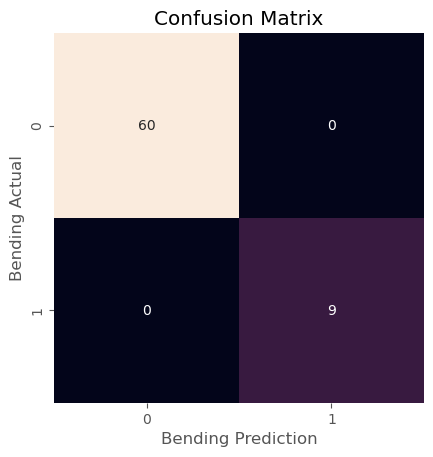


ROC for l = 11, and the AUC = 1.00


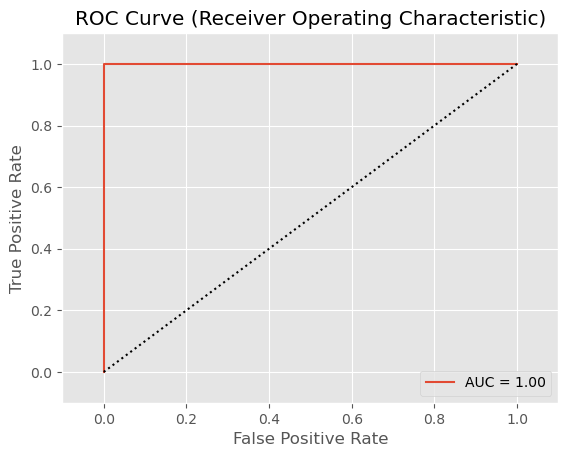

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              isBending   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.245e+24
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           1.16e-37
Time:                        13:54:14   Log-Likelihood:                 2047.0
No. Observations:                  69   AIC:                            -3962.
Df Residuals:                       3   BIC:                            -3815.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1132    7.2e-13   2.94e+12      0.000       2.113       2.113
mean5         -0.2979   1.64e-13  -1.81e+12      0.000      -0.298      -0.298
median5        0.2463   1.58e-13   1.56e+12      0.000       0.246       0.246
mean6         -0.3681   3.67e-13     -1e+12      0.000      -0.368      -0.368
median6        0.3560   3.52e-13   1.01e+12      0.000       0.356       0.356
mean10        -0.7880   5.12e-13  -1.54e+12      0.000      -0.788      -0.788
median10       0.8828   5.09e-13   1.73e+12      0.000       0.883       0.883
mean11         0.4385   2.73e-13    1.6e+12      0.000       0.439       0.439
median11      -0.3013   1.93e-13  -1.56e+12      0.000      -0.301      -0.301
mean12         0.4389   2.67e-13   1.64e+12      0.000       0.439       0.439
std15          0.0556    1.2e-13   4.61e+11      0.000       0.056       0.056
mean17         0.2757   2.04e-13   1.35e+12      0.000       0.276       0.276
median17      -0.3258   2.56e-13  -1.27e+12      0.000      -0.326      -0.326
mean18        -0.7655   3.93e-13  -1.95e+12      0.000      -0.766      -0.766
mean19         0.1118   2.31e-13   4.84e+11      0.000       0.112       0.112
median19      -0.0627   1.73e-13  -3.63e+11      0.000      -0.063      -0.063
std19          0.0361    1.7e-13   2.12e+11      0.000       0.036       0.036
mean21        -0.0459   5.83e-14  -7.87e+11      0.000      -0.046      -0.046
mean22        -0.0882   2.41e-13  -3.67e+11      0.000      -0.088      -0.088
mean24         1.6332   9.79e-13   1.67e+12      0.000       1.633       1.633
median24      -0.7358   3.72e-13  -1.98e+12      0.000      -0.736      -0.736
mean25        -0.1694   9.49e-14  -1.79e+12      0.000      -0.169      -0.169
std27          0.1548    2.1e-13   7.36e+11      0.000       0.155       0.155
mean28        -0.2952   6.49e-13  -4.55e+11      0.000      -0.295      -0.295
median28       0.6514   5.56e-13   1.17e+12      0.000       0.651       0.651
mean29        -0.0852   3.91e-14  -2.18e+12      0.000      -0.085      -0.085
mean31         0.4260   1.81e-13   2.36e+12      0.000       0.426       0.426
median31      -0.2988   1.63e-13  -1.84e+12      0.000      -0.299      -0.299
std31         -0.1935   1.22e-13  -1.59e+12      0.000      -0.193      -0.193
mean32         0.0996    2.1e-13   4.73e+11      0.000       0.100       0.100
mean34         0.7118   9.42e-13   7.56e+11      0.000       0.712       0.712
median34      -0.3262   5.78e-13  -5.65e+11      0.000      -0.326      -0.326
mean35        -0.2744   3.02e-13  -9.07e+11      0.000      -0.274      -0.274
median35       0.3843    3.2e-13    1.2e+12      0.000       0.384       0.384
std35         -0.0059   1.28e-13  -4.63e+10      0.000      -0.006      -0.006
mean36        -0.8760    5.3e-13  -1.65e+12      0.000      -0.876      -0.876
me

In [62]:
l = 10
instance_list = np.arange(0,88)
idx = 1
trainList = []
ltimeFeatures = pd.DataFrame()
for i in instance_list:
    data = train_data[train_data['instance']==i]
    numRows = int(data.shape[0] / l)
    if(numRows == 0):
        continue
    dataDictionary = {}
    dataDictionary['instance'] = data.iloc[1]["instance"]
    dataDictionary['isBending'] = data.iloc[1]["isBending"]
    idx = 1
    for s in np.arange(0,l):
        data_slice = data.iloc[s*numRows:(s+1)*numRows]
        for c in range(1, np.size(colNames)):
            col = data_slice.iloc[:,c]
            colDetails = pd.DataFrame(col.describe()).transpose()
            dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
            dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
            dataDictionary['std'+ str(idx)] = colDetails["std"][0]
            idx+=1
                
                
    ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
    idx += 1
train_x = ltimeFeatures.iloc[:,2:]
train_y = ltimeFeatures[['isBending']]
lrg = LogisticRegression()
rfecv = RFECV(estimator = lrg, cv = StratifiedKFold(5), scoring = 'accuracy')
rfecv.fit(train_x, train_y.values)

scores = []
for k,v in enumerate(rfecv.support_):
    if v == True:
        scores.append(k)

        
x_train_2 = train_x.iloc[:,scores]
model = lrg.fit(x_train_2, train_y.values.ravel())
y_predict = model.predict(x_train_2)
        
mat = confusion_matrix(train_y,y_predict)
tn, fp, fn, tp = confusion_matrix(train_y, y_predict).ravel()

true_positive_rate = tp / (tp + fn)
true_negative_rate = tn / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2* ((precision * recall) / (precision + recall))

sns.heatmap(mat,square= True, annot=True, cbar= False)
plt.xlabel("Bending Prediction")
plt.ylabel("Bending Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(train_y, y_predict)
roc_auc = auc(fpr,tpr)
print("\nROC for l = 11, and the AUC = %.2f"% auc(fpr,tpr))
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color='black',  linestyle=':')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Receiver Operating Characteristic)')
plt.show()

x_train_2 = sm.add_constant(x_train_2)
lm_1 = sm.OLS(train_y, x_train_2).fit()
lm_1.summary()



### 2. (a) iv. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [63]:
l_list = np.arange(1,21)
instance_list = np.arange(0,88)
idx = 1
testList = []
for l in [10]:
    ltimeFeatures = pd.DataFrame()
    for i in instance_list:
        data = test_data[test_data['instance']==i]
        numRows = int(data.shape[0] / l)
        if(numRows == 0):
            continue
        dataDictionary = {}
        dataDictionary['instance'] = data.iloc[1]["instance"]
        dataDictionary['isBending'] = data.iloc[1]["isBending"]
        idx = 1
        for s in np.arange(0,l):
            data_slice = data.iloc[s*numRows:(s+1)*numRows]
            for c in range(1, np.size(colNames)):
                col = data_slice.iloc[:,c]
                colDetails = pd.DataFrame(col.describe()).transpose()
                dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
                dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
                dataDictionary['std'+ str(idx)] = colDetails["std"][0]
                idx+=1
                
                
        ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
        idx += 1
    test_x = ltimeFeatures.iloc[:,2:]
    scaler = StandardScaler()
    test_x = scaler.fit_transform(test_x)
    test_y = ltimeFeatures[['isBending']]
    lrg = LogisticRegression()
    rfecv = RFECV(estimator = lrg, cv = StratifiedKFold(5))
    rfecv.fit(test_x, test_y.values)
    
    testList.append({'l':l,'Features (p)':rfecv.n_features_,'Cross Validation Score':max(rfecv.cv_results_["mean_test_score"])})

testList = pd.DataFrame(testList)
display(testList)
            



l  Features (p)  Cross Validation Score
0  10            12                    0.95

The accuracy of the test data is:0.95, whilst the accuracy of the training data was: 0.971429. 

### 2. (a) vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?


The classes do not seem to be esepecially well separated, which could cause instability in calculating logistic regression parameters, as seen in following plots.

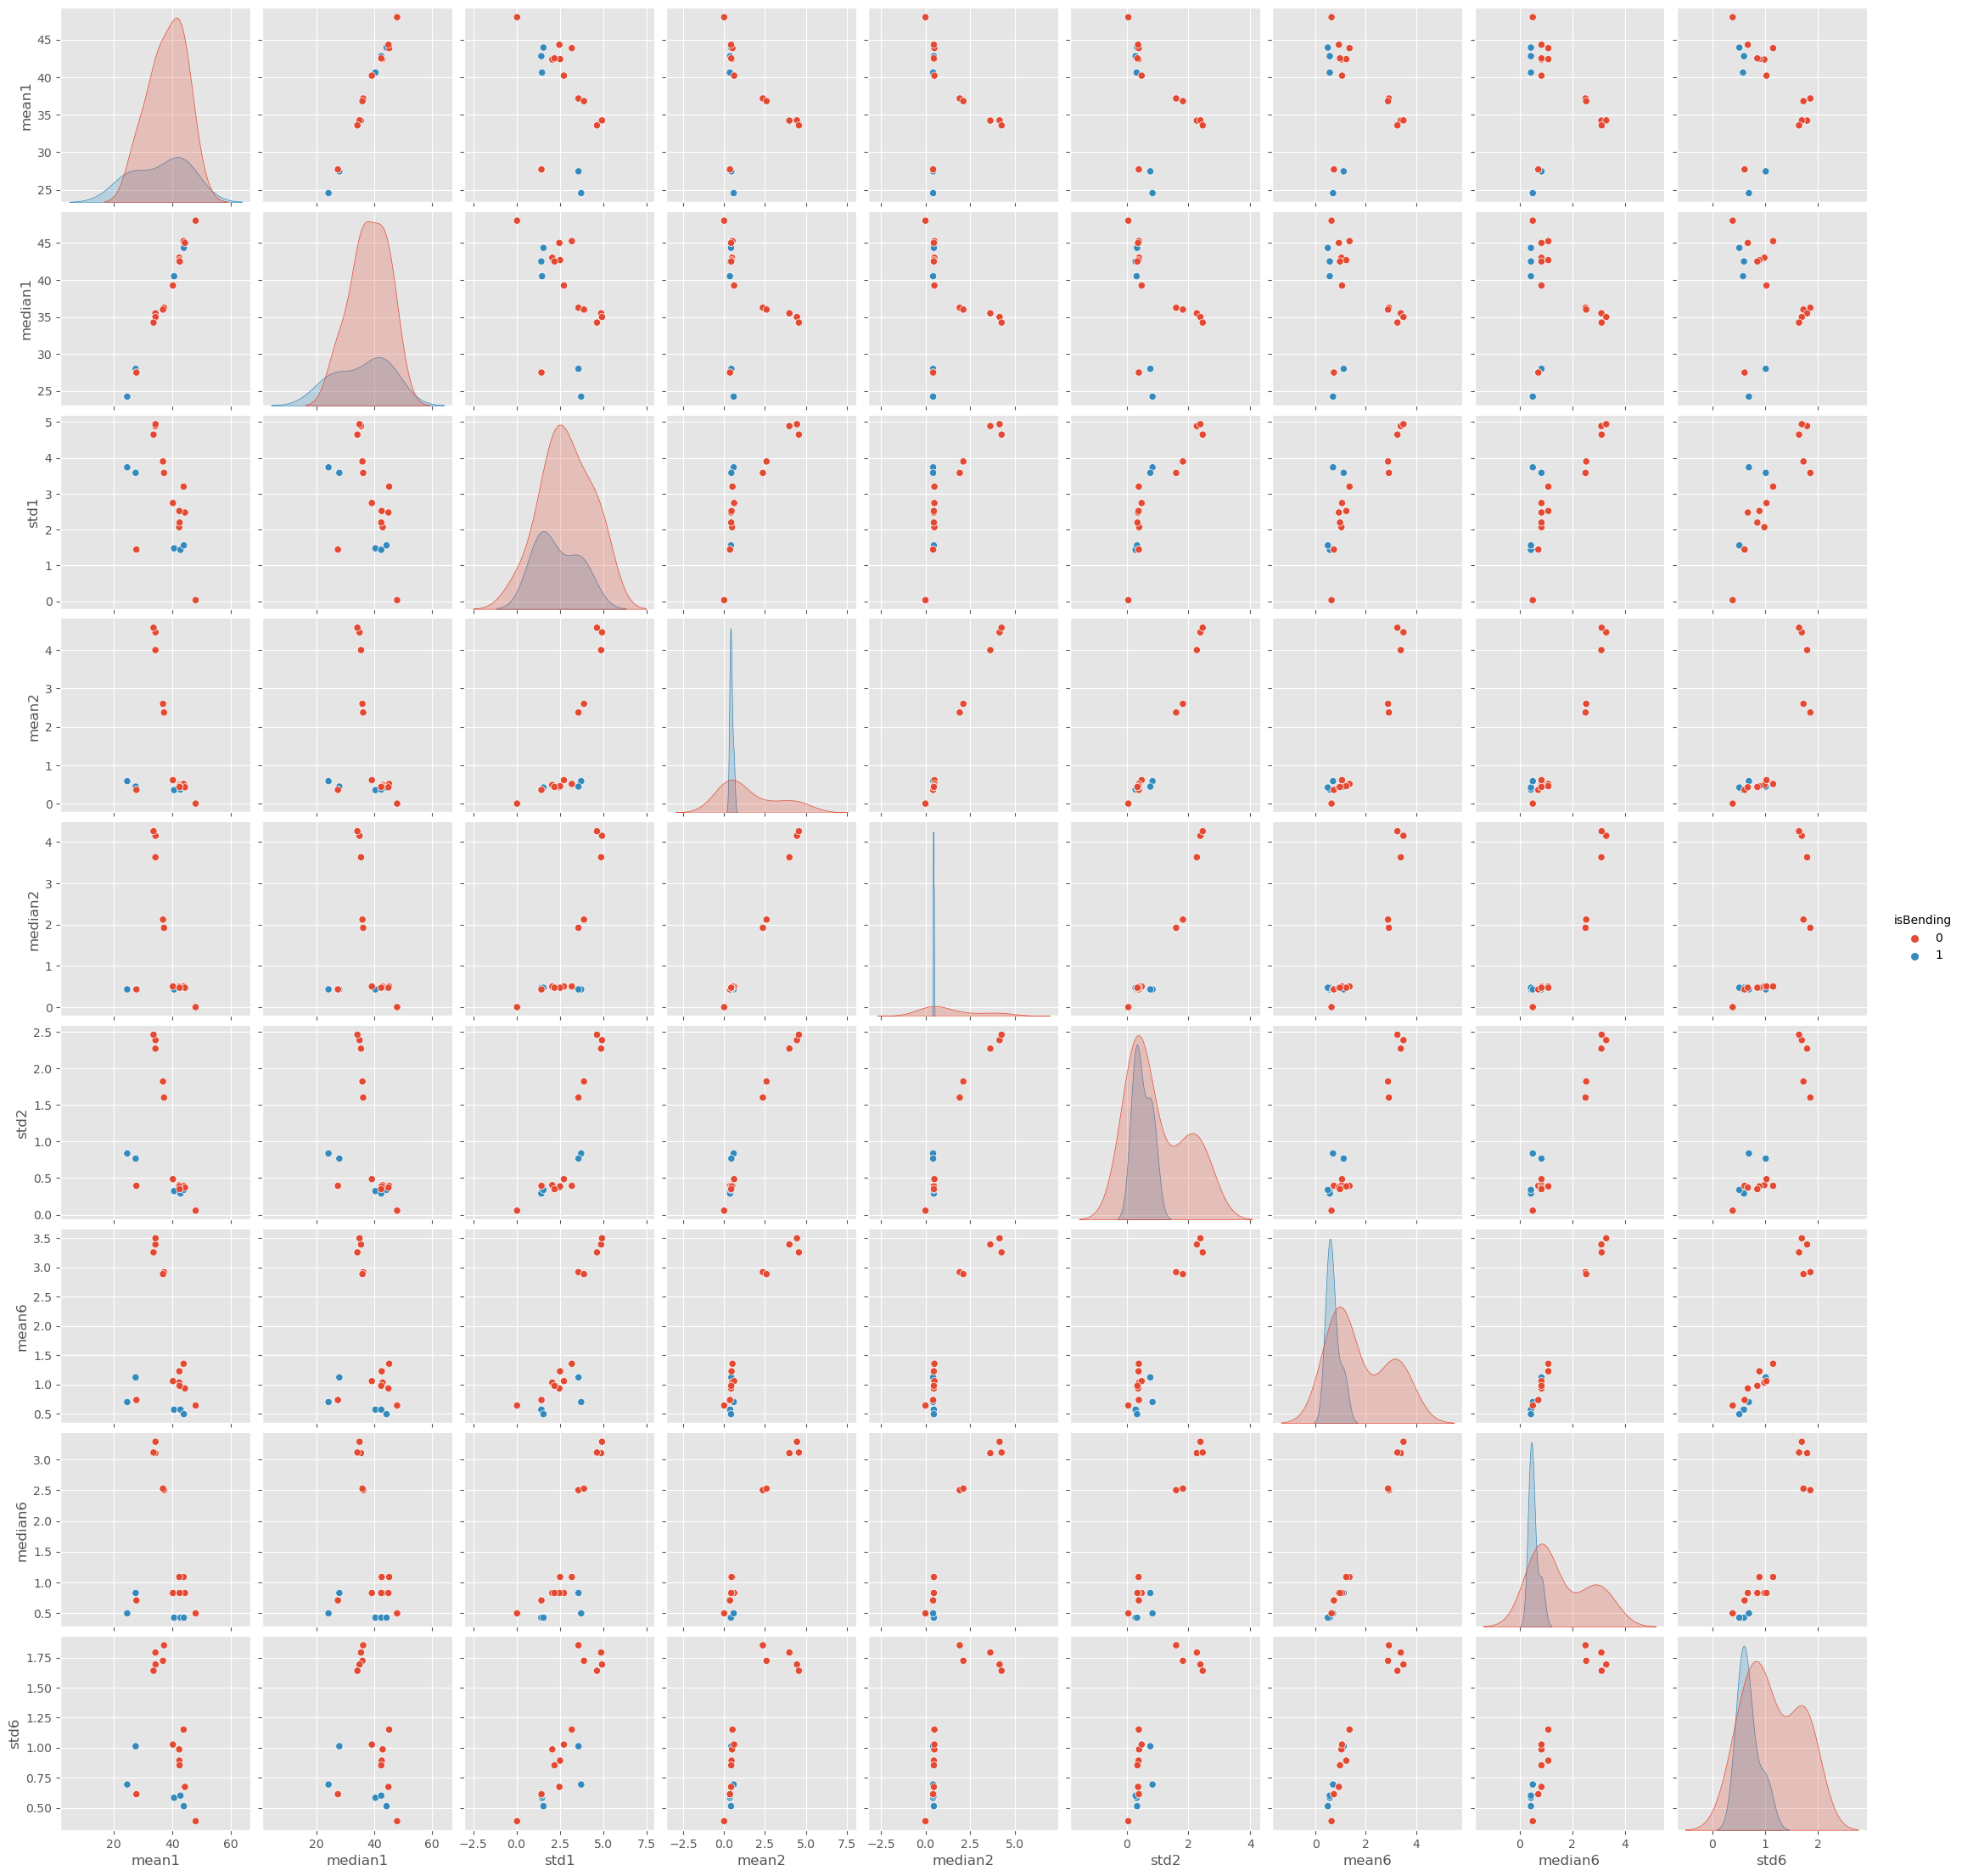

In [64]:
testFeatures = timeFeatures[timeFeatures["isTrain"]==False]
testFeatures = testFeatures[['isBending','mean1', 'median1', 'std1', 'mean2', 'median2', 'std2','mean6', 'median6', 'std6']]
sns.pairplot(testFeatures, hue = "isBending")
plt.show()

### 2. (a) vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.


Resampled dataset shape Counter({'isBending': 1})


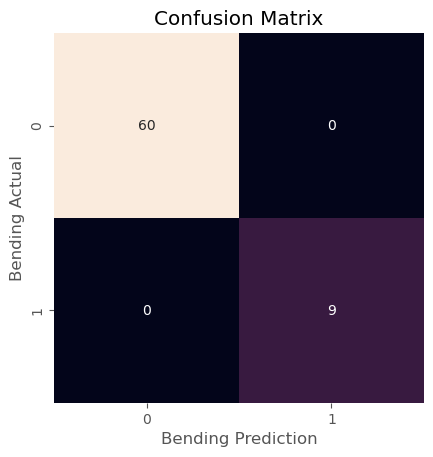


ROC for l = 11, and the AUC = 1.00


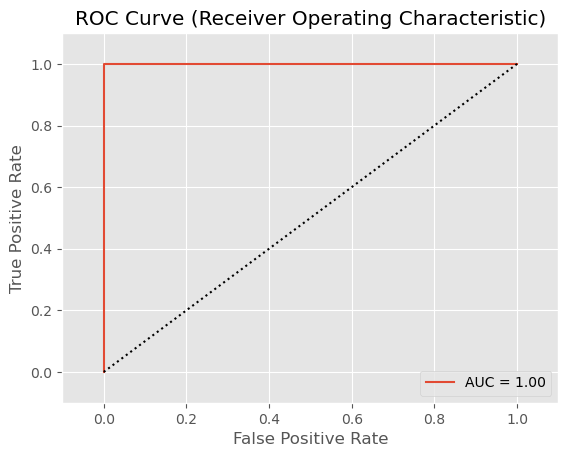

In [65]:
# case control sampling

l_list = np.arange(1,21)
instance_list = np.arange(0,88)
idx = 1
testList = []
for l in [10]:
    ltimeFeatures = pd.DataFrame()
    for i in instance_list:
        data = train_data[train_data['instance']==i]
        numRows = int(data.shape[0] / l)
        if(numRows == 0):
            continue
        dataDictionary = {}
        dataDictionary['instance'] = data.iloc[1]["instance"]
        dataDictionary['isBending'] = data.iloc[1]["isBending"]
        idx = 1
        for s in np.arange(0,l):
            data_slice = data.iloc[s*numRows:(s+1)*numRows]
            for c in range(1, np.size(colNames)):
                col = data_slice.iloc[:,c]
                colDetails = pd.DataFrame(col.describe()).transpose()
                dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
                dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
                dataDictionary['std'+ str(idx)] = colDetails["std"][0]
                idx+=1
                
                
        ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
        idx += 1
    train_x = ltimeFeatures.iloc[:,2:]
    train_y = ltimeFeatures[['isBending']]
    sm = SMOTE(random_state = 42)
    x_res, y_res = sm.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(y_res))
    lrg = LogisticRegression()
    rfecv = RFECV(estimator = lrg, cv = StratifiedKFold(5))
    rfecv.fit(x_res, y_res)
    lrg.fit(x_res, y_res)
    y_pred=lrg.predict(x_res)
    # conf matrix
    tn, fp, fn, tp = confusion_matrix(y_res, y_pred).ravel()

    true_positive_rate = tp / (tp + fn)
    true_negative_rate = tn / (tn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2* ((precision * recall) / (precision + recall))

    sns.heatmap(mat,square= True, annot=True, cbar= False)
    plt.xlabel("Bending Prediction")
    plt.ylabel("Bending Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
fpr, tpr, thresholds = roc_curve(y_res, y_pred)
roc_auc = auc(fpr,tpr)
print("\nROC for l = 11, and the AUC = %.2f"% auc(fpr,tpr))
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color='black',  linestyle=':')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Receiver Operating Characteristic)')
plt.show()
    
    

### 2. (b) Binary Classification Using L1-penalized logistic regression.

#### (i.) Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using pvalues for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [66]:
instance_list = np.arange(0,88)
idx = 1
resultList = []
maxVal = 0
for l in l_list:
    ltimeFeatures = pd.DataFrame()
    for i in instance_list:
        data = train_data[train_data['instance']==i]
        numRows = int(data.shape[0] / l)
        if(numRows == 0):
            continue
        dataDictionary = {}
        dataDictionary['instance'] = data.iloc[1]["instance"]
        dataDictionary['isBending'] = data.iloc[1]["isBending"]
        idx = 1
        for s in np.arange(0,l):
            data_slice = data.iloc[s*numRows:(s+1)*numRows]
            for c in range(1, np.size(colNames)):
                col = data_slice.iloc[:,c]
                colDetails = pd.DataFrame(col.describe()).transpose()
                dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
                dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
                dataDictionary['std'+ str(idx)] = colDetails["std"][0]
                idx+=1
                
                
        ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
        idx += 1
    train_x = ltimeFeatures.iloc[:,2:]
    train_y = ltimeFeatures[['isBending']]
    
    c_list=[10, 1, .1, .001]
    for c in c_list:
        clf_l1_LR=LogisticRegression(C=c, penalty="l1", solver="liblinear")
        clf_l1_LR.fit(train_x, train_y)
        
        cv_score =cross_val_score(clf_l1_LR,train_x,train_y,cv=5)
        cv_accuracy=cv_score.mean()
        if(cv_accuracy > maxVal):
            maxVal = cv_accuracy
            resultList = {"maxVal":maxVal, "c":c, "l":l}
display(resultList)
        
        
        
    

{'maxVal': 0.9714285714285715, 'c': 10, 'l': 5}

### 2. (b) ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?


The L1-penalized model was easier to implement, however it did have a slightly lower maximum value for the accuracy. The results were as follows:<br>
The L1-penalized model achieved a maximum accuracy of:0.9571428571428571. <br>
The variable selection model using p-values achieved a maximum accuracy of:  0.971429.

### 2. (c) Multi-class Classification (The Realistic Case)
#### i. Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set.10 Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.11

In [67]:
instance_list = np.arange(0,88)
idx = 1
resultList = []
maxVal = 0
for l in l_list:
    ltimeFeatures = pd.DataFrame()
    for i in instance_list:
        data = train_data[train_data['instance']==i]
        numRows = int(data.shape[0] / l)
        if(numRows == 0):
            continue
        dataDictionary = {}
        dataDictionary['instance'] = data.iloc[1]["instance"]
        if data.iloc[1]["folder"] == 'bending1' or data.iloc[1]["folder"] == 'bending2':
            dataDictionary['class'] = 1
        if data.iloc[1]["folder"] == 'cycling':
            dataDictionary['class'] = 2
        if data.iloc[1]["folder"] == 'lying':
            dataDictionary['class'] = 3
        if data.iloc[1]["folder"] == 'sitting':
            dataDictionary['class'] = 4
        if data.iloc[1]["folder"] == 'standing':
            dataDictionary['class'] = 5
        if data.iloc[1]["folder"] == 'walking':
            dataDictionary['class'] = 6
        idx = 1
        for s in np.arange(0,l):
            data_slice = data.iloc[s*numRows:(s+1)*numRows]
            for c in range(1, np.size(colNames)):
                col = data_slice.iloc[:,c]
                colDetails = pd.DataFrame(col.describe()).transpose()
                dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
                dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
                dataDictionary['std'+ str(idx)] = colDetails["std"][0]
                idx+=1
                
                
        ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
        idx += 1
    train_x = ltimeFeatures.iloc[:,2:]
    train_y = ltimeFeatures[['class']]
    
    c_list=np.arange(10,101,10)
    for c in c_list:
        c = c/1000
        clf_l1_LR=LogisticRegression(C=c, penalty="l1", solver='saga', multi_class="multinomial")
        clf_l1_LR = clf_l1_LR.fit(train_x, train_y)
        
        cv_score =cross_val_score(clf_l1_LR,train_x,train_y,cv=5, scoring='accuracy')
        cv_accuracy=cv_score.mean()
        #print({"Accuracy":cv_accuracy, "c":c, "l":l})
        if(cv_accuracy > maxVal):
            maxVal = cv_accuracy
            resultList = {"maxVal":maxVal, "c":c, "l":l}
display(resultList)
        
        
        
    

{'maxVal': 0.724175824175824, 'c': 0.1, 'l': 15}

In [68]:
## test error

instance_list = np.arange(0,88)
idx = 1
resultList = []
maxVal = 0
l = 15
ltimeFeatures = pd.DataFrame()
for i in instance_list:
    data = test_data[test_data['instance']==i]
    numRows = int(data.shape[0] / l)
    if(numRows == 0):
        continue
    dataDictionary = {}
    dataDictionary['instance'] = data.iloc[1]["instance"]
    if data.iloc[1]["folder"] == 'bending1' or data.iloc[1]["folder"] == 'bending2':
        dataDictionary['class'] = 1
    if data.iloc[1]["folder"] == 'cycling':
        dataDictionary['class'] = 2
    if data.iloc[1]["folder"] == 'lying':
        dataDictionary['class'] = 3
    if data.iloc[1]["folder"] == 'sitting':
        dataDictionary['class'] = 4
    if data.iloc[1]["folder"] == 'standing':
        dataDictionary['class'] = 5
    if data.iloc[1]["folder"] == 'walking':
        dataDictionary['class'] = 6
    idx = 1
    for s in np.arange(0,l):
        data_slice = data.iloc[s*numRows:(s+1)*numRows]
        for c in range(1, np.size(colNames)):
            col = data_slice.iloc[:,c]
            colDetails = pd.DataFrame(col.describe()).transpose()
            dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
            dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
            dataDictionary['std'+ str(idx)] = colDetails["std"][0]
            idx+=1
                
                
    ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
    idx += 1
display(ltimeFeatures)
test_x = ltimeFeatures.iloc[:,2:]
test_y = ltimeFeatures[['class']]
    
c = 0.1
clf_l1_LR=LogisticRegression(C=c, penalty="l1", solver='saga', multi_class="multinomial")
clf_l1_LR = clf_l1_LR.fit(test_x, test_y)
        
cv_score =cross_val_score(clf_l1_LR,test_x,test_y,cv=4)
cv_accuracy=cv_score.mean()

resultList = {"test error maxVal":cv_accuracy, "c":c, "l":l}
display(resultList)
        
        
        
    

instance  class      mean1  median1      std1     mean2  median2  \
0        0.0    1.0  39.927188   39.500  0.622094  0.532813    0.500   
1        1.0    1.0  43.463750   43.500  0.466523  0.511250    0.485   
2        7.0    1.0  19.973750   20.625  3.025529  1.269688    0.790   
3        8.0    1.0  27.018125   27.000  0.131479  0.070625    0.000   
4       13.0    2.0  36.338437   34.875  3.974327  2.552813    2.490   
5       14.0    2.0  37.036250   35.500  4.185502  2.312500    1.880   
6       15.0    2.0  37.120000   36.625  4.142607  2.471250    1.645   
7       28.0    3.0  28.953125   29.000  0.117732  0.069375    0.000   
8       29.0    3.0  28.953125   29.000  0.117732  0.069375    0.000   
9       30.0    3.0  48.000000   48.000  0.000000  0.000000    0.000   
10      43.0    4.0  41.984375   42.000  0.061484  0.026875    0.000   
11      44.0    4.0  42.000000   42.000  0.000000  0.000000    0.000   
12      45.0    4.0  40.816250   39.625  3.302890  0.822500    0.830   
13      58.0    5.0  46.450313   46.500  0.186262  0.509688    0.500   
14      59.0    5.0  38.432500   37.670  2.053185  0.846562    0.905   
15      60.0    5.0  44.924375   45.000  0.216526  0.077187    0.000   
16      73.0    6.0  34.610312   36.000  4.713620  3.950625    3.670   
17      74.0    6.0  35.171875   35.625  4.793493  3.980937    3.600   
18      75.0    6.0  34.900937   35.460  4.396691  4.097187    4.335   

        std2      mean3  median3  ...     std87    mean88  median88     std88  \
0   0.185737  21.065313   22.625  ...  0.541272  0.507188     0.470  0.291063   
1   0.104781  18.734375   19.875  ...  6.020301  1.531562     1.455  1.218368   
2   1.221423  22.967813   23.710  ...  1.073494  0.336250     0.430  0.333725   
3   0.167138  19.339687   20.500  ...  2.471111  0.701562     0.710  0.630587   
4   1.615975  16.550937   17.415  ...  2.999358  2.766250     2.475  1.729368   
5   1.546878  14.692500   14.375  ...  3.881088  3.127812     2.490  1.713182   
6   2.024383  16.913750   16.000  ...  3.836255  3.511250     3.095  2.108909   
7   0.164178   7.510937    7.625  ...  2.934487  0.920625     0.940  0.600000   
8   0.164178   7.504062    7.625  ...  2.934487  0.920625     0.940  0.600000   
9   0.000000   5.745000    5.875  ...  2.563156  0.536250     0.485  0.365538   
10  0.105752  17.118125   17.500  ...  2.290673  0.697187     0.470  0.821271   
11  0.000000  19.864063   20.425  ...  3.574188  0.856250     0.605  0.829826   
12  0.556574  17.707812   17.415  ...  4.261133  1.525625     1.355  0.927421   
13  0.138947  12.736875   12.000  ...  0.514612  0.416562     0.450  0.284782   
14  0.295925  17.058125   16.750  ...  2.997780  0.325937     0.430  0.297851   
15  0.187431  16.802188   16.710  ...  4.149707  1.580312     1.350  1.301445   
16  2.460269  16.166875   16.375  ...  2.801175  3.602813     3.690  1.694668   
17  2.228711  14.822812   15.335  ...  3.014350  3.181875     3.270  1.826482   
18  2.627865  15.638125   16.250  ...  2.909193  2.950000     2.740  1.595350   

       mean89  median89     std89    mean90  median90     std90  
0   30.434687    30.250  0.932976  0.248750     0.000  0.295414  
1   32.033750    32.000  1.052646  0.332812     0.430  0.380002  
2   20.533438    20.710  1.034488  0.585000     0.500  0.283458  
3   24.724062    25.670  4.249555  2.148438     1.500  1.296601  
4   20.078125    20.710  2.668200  2.614375     2.405  1.603653  
5   16.486875    15.750  3.032736  3.290937     3.285  1.505248  
6   17.570000    17.750  3.304815  3.296875     2.650  2.164099  
7   10.148750    10.250  1.392099  0.912500     0.830  0.395947  
8   10.148750    10.250  1.392099  0.912500     0.830  0.395947  
9   10.164062    10.125  0.788199  0.651562     0.770  0.338956  
10  18.365000    17.750  5.083250  1.212813     0.830  1.338645  
11  17.984375    18.250  3.756705  1.256563     0.830  1.288028  
12  12.796563    13.415  3.139180  1.564687     1.275  1.121678  
13  15.520625    1

{'test error maxVal': 0.36250000000000004, 'c': 0.1, 'l': 15}

In [69]:
# confusion matrices/ROC curves

# get training x and y for best l
instance_list = np.arange(0,88)
idx = 1
resultList = []
maxVal = 0
l = 15
ltimeFeatures = pd.DataFrame()
for i in instance_list:
    data = train_data[train_data['instance']==i]
    numRows = int(data.shape[0] / l)
    if(numRows == 0):
        continue
    dataDictionary = {}
    dataDictionary['instance'] = data.iloc[1]["instance"]
    if data.iloc[1]["folder"] == 'bending1' or data.iloc[1]["folder"] == 'bending2':
        dataDictionary['class'] = 1
    if data.iloc[1]["folder"] == 'cycling':
        dataDictionary['class'] = 2
    if data.iloc[1]["folder"] == 'lying':
        dataDictionary['class'] = 3
    if data.iloc[1]["folder"] == 'sitting':
        dataDictionary['class'] = 4
    if data.iloc[1]["folder"] == 'standing':
        dataDictionary['class'] = 5
    if data.iloc[1]["folder"] == 'walking':
        dataDictionary['class'] = 6
    idx = 1
    for s in np.arange(0,l):
        data_slice = data.iloc[s*numRows:(s+1)*numRows]
        for c in range(1, np.size(colNames)):
            col = data_slice.iloc[:,c]
            colDetails = pd.DataFrame(col.describe()).transpose()
            dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
            dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
            dataDictionary['std'+ str(idx)] = colDetails["std"][0]
            idx+=1
                
                
    ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
    idx += 1
display(ltimeFeatures)
train_x = ltimeFeatures.iloc[:,2:]
train_y = ltimeFeatures[['class']]
c = 0.1



instance  class      mean1  median1      std1     mean2  median2  \
0        2.0    1.0  43.885312   45.000  1.546985  0.290625    0.000   
1        3.0    1.0  43.424375   45.000  3.731713  0.713125    0.500   
2        4.0    1.0  41.839375   42.000  2.206787  0.460938    0.485   
3        5.0    1.0  44.786250   45.000  1.072617  0.247812    0.000   
4        6.0    1.0  42.687500   42.670  0.888246  0.460313    0.485   
..       ...    ...        ...      ...       ...       ...      ...   
64      83.0    6.0  35.612188   35.625  4.527872  3.929375    3.900   
65      84.0    6.0  34.379063   35.500  4.508697  4.520625    4.710   
66      85.0    6.0  34.322500   33.875  4.584414  3.808125    3.960   
67      86.0    6.0  36.554688   37.415  4.931219  4.637187    4.045   
68      87.0    6.0  34.664062   35.000  5.143127  4.013125    3.585   

        std2      mean3  median3  ...     std87    mean88  median88     std88  \
0   0.337371  22.544375   23.750  ...  2.477467  0.361250     0.430  0.359002   
1   0.736033  24.853438   24.250  ...  4.625089  1.224687     0.830  1.250337   
2   0.400382  21.942500   23.750  ...  2.784234  0.527188     0.450  0.483323   
3   0.346659  17.679375   17.875  ...  2.369073  0.799375     0.710  0.645015   
4   0.291619  16.114687   16.625  ...  4.116647  1.043438     0.685  0.997046   
..       ...        ...      ...  ...       ...       ...       ...       ...   
64  2.029626  15.231875   15.665  ...  2.704156  3.257812     3.420  1.572370   
65  2.328188  15.408750   16.250  ...  2.624041  2.835625     2.785  1.285153   
66  2.364351  15.237500   15.125  ...  3.481413  3.211250     2.640  1.940837   
67  2.867131  14.872500   14.875  ...  3.917813  3.123437     2.800  1.682202   
68  2.416766  15.111875   15.000  ...  2.367690  3.430625     3.015  2.130505   

       mean89  median89     std89    mean90  median90     std90  
0   36.028437    36.000  0.220295  0.166563     0.000  0.310594  
1   29.784062    30.000  3.016091  0.498437     0.430  0.509498  
2   27.320312    27.000  1.287712  0.322187     0.430  0.296786  
3   20.213438    21.415  3.780186  0.897187     0.710  0.891733  
4   22.874375    23.000  1.055431  0.657500     0.500  0.420967  
..        ...       ...       ...       ...       ...       ...  
64  15.226875    15.000  3.100449  3.590312     3.560  1.624860  
65  15.328750    15.585  3.008241  3.070625     3.345  1.663979  
66  16.952187    17.375  3.535184  3.410625     3.280  1.848265  
67  16.153750    16.415  3.000782  3.482188     3.155  1.593039  
68  16.030313    15.625  3.409759  3.430937     3.530  1.213362  

[69 rows x 272 columns]

[[3 0 0 0 0 0]
 [1 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 2 3 0]
 [0 0 0 0 0 3]]


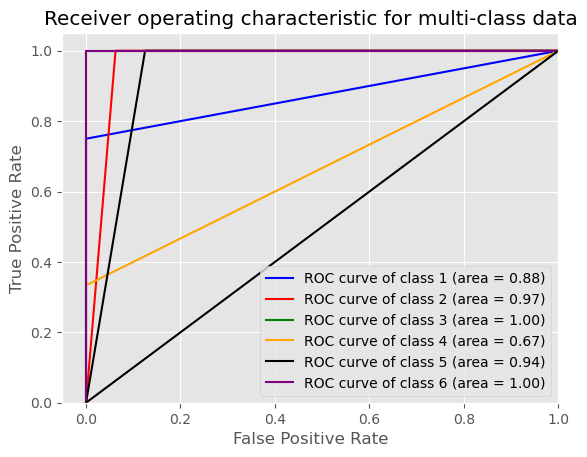

In [70]:

plt.style.use('ggplot')
train_y_bin = label_binarize(train_y, classes=[1,2,3,4,5,6])
n_classes = train_y_bin.shape[1]
test_y_bin = label_binarize(test_y, classes=[1,2,3,4,5,6])

logreg=LogisticRegression(C=c,penalty='l1',solver='saga',multi_class="multinomial")
logreg.fit(train_x,train_y)
predict_y=logreg.predict(test_x)
predict_y_bin = label_binarize(predict_y, classes=[1,2,3,4,5,6])
    
mat=confusion_matrix(predict_y,test_y)  
print(mat)

# Plotting and estimation of FPR, TPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], predict_y_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange','black','purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()



### 2(c) ii. Repeat 2(c)i using a Na¨ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results

In [71]:
# Find best l

instance_list = np.arange(0,88)
idx = 1
resultListG = []
maxValG = 0

resultListM = []
maxValM = 0
for l in l_list:
    ltimeFeatures = pd.DataFrame()
    for i in instance_list:
        data = train_data[train_data['instance']==i]
        numRows = int(data.shape[0] / l)
        if(numRows == 0):
            continue
        dataDictionary = {}
        dataDictionary['instance'] = data.iloc[1]["instance"]
        if data.iloc[1]["folder"] == 'bending1' or data.iloc[1]["folder"] == 'bending2':
            dataDictionary['class'] = 1
        if data.iloc[1]["folder"] == 'cycling':
            dataDictionary['class'] = 2
        if data.iloc[1]["folder"] == 'lying':
            dataDictionary['class'] = 3
        if data.iloc[1]["folder"] == 'sitting':
            dataDictionary['class'] = 4
        if data.iloc[1]["folder"] == 'standing':
            dataDictionary['class'] = 5
        if data.iloc[1]["folder"] == 'walking':
            dataDictionary['class'] = 6
        idx = 1
        for s in np.arange(0,l):
            data_slice = data.iloc[s*numRows:(s+1)*numRows]
            for c in range(1, np.size(colNames)):
                col = data_slice.iloc[:,c]
                colDetails = pd.DataFrame(col.describe()).transpose()
                dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
                dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
                dataDictionary['std'+ str(idx)] = colDetails["std"][0]
                idx+=1
                
                
        ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
        idx += 1
    train_x = ltimeFeatures.iloc[:,2:]
    train_y = ltimeFeatures[['class']]
    
    # create a Gaussian Classifier
    gclassifier = GaussianNB()
    # train the model using the training sets
    gclassifier.fit(train_x, train_y)
    gscore=gclassifier.score(train_x,train_y)
    g_cvscore=cross_val_score(gclassifier,train_x,train_y,cv=5).mean()
    if(g_cvscore > maxValG):
        maxValG = g_cvscore
        resultListG = {"maxVal Gaussian":maxValG, "l":l}
        maxClassifierG = gclassifier
        train_x_g = train_x
        train_y_g = train_y
    
    # create multinomial classifer
    mclassifier = MultinomialNB()
    mclassifier.fit(train_x,train_y)
    mscore = mclassifier.score(train_x,train_y)
    m_cvscore=cross_val_score(mclassifier,train_x,train_y,cv=5).mean()
    if(m_cvscore > maxValM):
        maxValM = m_cvscore
        resultListM = {"maxVal Multinomial":maxValM, "l":l}
        maxClassifierM = mclassifier
        train_x_m = train_x
        train_y_m = train_y
    
display(resultListG)
display(resultListM)
        
        
        
    

{'maxVal Gaussian': 0.8571428571428571, 'l': 2}

{'maxVal Multinomial': 0.8846153846153847, 'l': 15}

In [72]:
## test error Gaussian

instance_list = np.arange(0,88)
idx = 1
resultList = []
maxVal = 0
l = 2 # max L from gaussian model above
ltimeFeatures = pd.DataFrame()
for i in instance_list:
    data = test_data[test_data['instance']==i]
    numRows = int(data.shape[0] / l)
    if(numRows == 0):
        continue
    dataDictionary = {}
    dataDictionary['instance'] = data.iloc[1]["instance"]
    if data.iloc[1]["folder"] == 'bending1' or data.iloc[1]["folder"] == 'bending2':
        dataDictionary['class'] = 1
    if data.iloc[1]["folder"] == 'cycling':
        dataDictionary['class'] = 2
    if data.iloc[1]["folder"] == 'lying':
        dataDictionary['class'] = 3
    if data.iloc[1]["folder"] == 'sitting':
        dataDictionary['class'] = 4
    if data.iloc[1]["folder"] == 'standing':
        dataDictionary['class'] = 5
    if data.iloc[1]["folder"] == 'walking':
        dataDictionary['class'] = 6
    idx = 1
    for s in np.arange(0,l):
        data_slice = data.iloc[s*numRows:(s+1)*numRows]
        for c in range(1, np.size(colNames)):
            col = data_slice.iloc[:,c]
            colDetails = pd.DataFrame(col.describe()).transpose()
            dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
            dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
            dataDictionary['std'+ str(idx)] = colDetails["std"][0]
            idx+=1
                
                
    ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
    idx += 1
test_x_g = ltimeFeatures.iloc[:,2:]
test_y_g = ltimeFeatures[['class']]


y_pred_g = maxClassifierG.predict(test_x_g)
print("Gaussian Test Accuracy:", metrics.accuracy_score(test_y_g, y_pred_g))
        
        
        
    

## multinomial test error

instance_list = np.arange(0,88)
idx = 1
resultList = []
maxVal = 0
l = 15
ltimeFeatures = pd.DataFrame()
for i in instance_list:
    data = test_data[test_data['instance']==i]
    numRows = int(data.shape[0] / l)
    if(numRows == 0):
        continue
    dataDictionary = {}
    dataDictionary['instance'] = data.iloc[1]["instance"]
    if data.iloc[1]["folder"] == 'bending1' or data.iloc[1]["folder"] == 'bending2':
        dataDictionary['class'] = 1
    if data.iloc[1]["folder"] == 'cycling':
        dataDictionary['class'] = 2
    if data.iloc[1]["folder"] == 'lying':
        dataDictionary['class'] = 3
    if data.iloc[1]["folder"] == 'sitting':
        dataDictionary['class'] = 4
    if data.iloc[1]["folder"] == 'standing':
        dataDictionary['class'] = 5
    if data.iloc[1]["folder"] == 'walking':
        dataDictionary['class'] = 6
    idx = 1
    for s in np.arange(0,l):
        data_slice = data.iloc[s*numRows:(s+1)*numRows]
        for c in range(1, np.size(colNames)):
            col = data_slice.iloc[:,c]
            colDetails = pd.DataFrame(col.describe()).transpose()
            dataDictionary['mean'+ str(idx)] = colDetails["mean"][0]
            dataDictionary['median'+ str(idx)] = colDetails["50%"][0]
            dataDictionary['std'+ str(idx)] = colDetails["std"][0]
            idx+=1
                
                
    ltimeFeatures = ltimeFeatures.append(dataDictionary, ignore_index=True)
    idx += 1
test_x_m = ltimeFeatures.iloc[:,2:]
test_y_m = ltimeFeatures[['class']]
    
y_pred_m = maxClassifierM.predict(test_x_m)

print("Multinomial Test Accuracy:", metrics.accuracy_score(test_y_m, y_pred_m))
        
        
        
    

Gaussian Test Accuracy: 0.7368421052631579
Multinomial Test Accuracy: 0.8947368421052632


Gaussian Confusion Matrix
[[4 0 0 1 1 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 1 2 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 3]]
Multinomial Confusion Matrix
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 2 3 0]
 [0 0 0 0 0 3]]


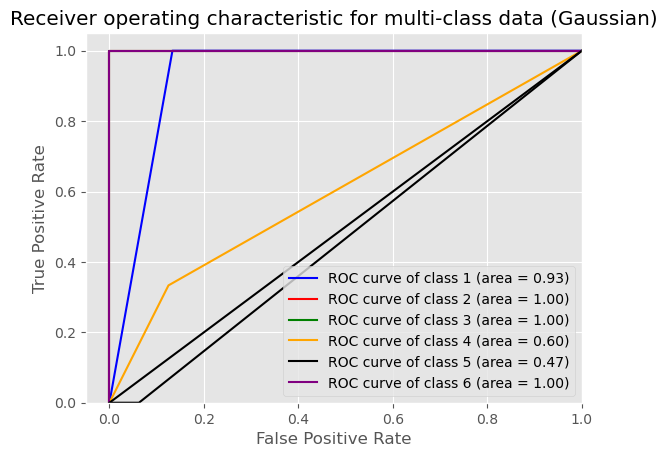

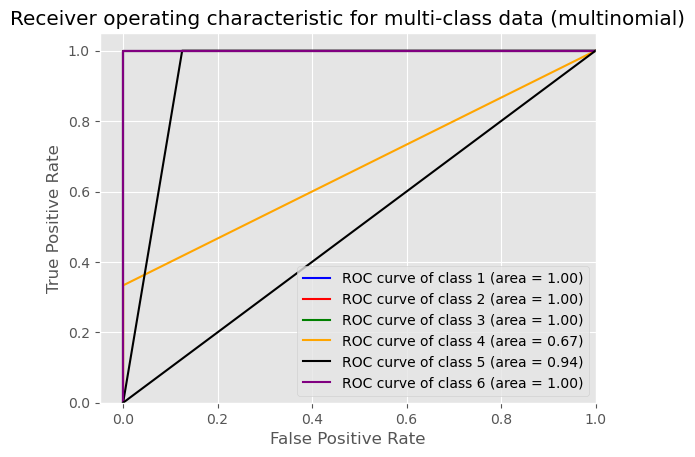

In [73]:
# Confusion Matrix and ROC curve

print("Gaussian Confusion Matrix")
mat=confusion_matrix(y_pred_g,test_y_g)  
print(mat)

print("Multinomial Confusion Matrix")
mat=confusion_matrix(y_pred_m,test_y_m)  
print(mat)

# Gaussian
plt.style.use('ggplot')
train_y_bin = label_binarize(train_y_g, classes=[1,2,3,4,5,6])
n_classes = train_y_bin.shape[1]
test_y_bin = label_binarize(test_y_g, classes=[1,2,3,4,5,6])
predict_y_bin = label_binarize(y_pred_g, classes=[1,2,3,4,5,6])

# Plotting and estimation of FPR, TPR Gaussian
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], predict_y_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange','black','purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data (Gaussian)')
plt.legend(loc="lower right")
plt.show()

# Multinomial
plt.style.use('ggplot')
train_y_bin = label_binarize(train_y_m, classes=[1,2,3,4,5,6])
n_classes = train_y_bin.shape[1]
test_y_bin = label_binarize(test_y_m, classes=[1,2,3,4,5,6])
predict_y_bin = label_binarize(y_pred_m, classes=[1,2,3,4,5,6])

# Plotting and estimation of FPR, TPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], predict_y_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange','black','purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data (multinomial)')
plt.legend(loc="lower right")
plt.show()




### 2(c) iii. Which method is better for multi-class classification in this problem?

Based on the calculated values, for Train: <br>
{'maxVal Gaussian': 0.8571428571428571, 'l': 2}<br>
{'maxVal Multinomial': 0.8846153846153847, 'l': 15} <br>
and Test: <br>
Gaussian Test Accuracy: 0.7368421052631579<br>
Multinomial Test Accuracy: 0.8947368421052632<br>
It is clear that Multinomial Naive Bayes outperforms Gaussian Naive Bayes.

### 3. ISLR, 4.8.3

In [74]:
from IPython.display import IFrame
IFrame("../4.8.3.pdf", width=1000, height=300)

### 4. ISLR, 4.8.7

In [75]:
from IPython.display import IFrame
IFrame("../4.8.7.pdf", width=1000, height=300)

References: <br>
https://dataindependent.com/pandas/add-column-to-dataframe-pandas/ <br>
https://stackoverflow.com/questions/48042483/extra-commas-at-beginning-and-end-of-csv-rows-how-to-remove <br>
https://stats.stackexchange.com/questions/50807/features-for-time-series-classification <br>
https://www.digitalocean.com/community/tutorials/python-concatenate-string-and-int <br>
https://www.statology.org/bootstrapping-in-python/ <br>
https://stackoverflow.com/questions/27275236/how-to-select-all-columns-whose-names-start-with-x-in-a-pandas-dataframe <br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html <br>
https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html <br>
https://machinelearningmastery.com/multinomial-logistic-regression-with-python/ <br>
https://stackoverflow.com/questions/19470099/view-pdf-image-in-an-ipython-notebook <br>
https://towardsdatascience.com/roc-curve-explained-using-a-covid-19-hypothetical-example-binary-multi-class-classification-bab188ea869c <br>
https://hands-on.cloud/implementing-naive-bayes-classification-using-python/#h-training-the-model-using-multiclass-labels <br>
https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html <br>
